In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Goals of this notebook

* Build our first classification model and evaluate it on the hold-out sets.

* Try various features and understand what the model is doing.

### Read in data from previous day

In [107]:
DATA_PATH = "../data/walmart"
TRAIN_PATH = f"{DATA_PATH}/train.csv"
TEST_PATH = f"{DATA_PATH}/test.csv"

In [108]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test.feather')

### Modeling

The main technique we'll use today is **Logistic Regression**. Logistic regression is *not* a regression model - it is a classification model.

A quick summary:

Given n features - $x_1, x_2, \ldots, x_n$, and a binary target variable - $y \in {0,1}$, logistic regression predicts the probability this example belongs to class 1 as:

$$p = \sigma(w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n)$$

where $\sigma$ is the sigmoid function: $\sigma(x) = \frac{1}{1 + e^{-x}}$

As we discussed in the lecture, you can think of $\sigma$ as a softer switch function which "smoothifies" the discrete switch:

$s(x) = 
\begin{cases}
0, \text{ if x < 0} \\
1, \text{ if x} \geq 0
\end{cases}
$

This is a linear model since it uses the linear combination:

$$w_0 + w_1 x_1 + w_2 x_2 + \ldots + w_n x_n$$

In particular, this means that we don't take into account features like $x_i x_j$ or higher-order terms. If we do want to take those into account, we would have to explicitly create a features (column) $x_i x_j$.

There are other linear classification models. Some examples are:

[TBC]

# Featurization Strategy 1:

We want to predict the trip type of each VisitNumber. Our hypothesis is that one of the simplest predictors is the type of items bought on each trip. But we have several rows for each trip. How can we create a dataset with one row per visit and a description of all the items bought.

The first questions is whether we should use Upc, FinelineNumber or DepartmentDescription to describe what items were bought.

**Question**: What are the tradeoffs between choosing each one of these 3 options?


Description -> 1 hot
Description -> counts
Description -> normalized counts + Counts column
Description -> normalized counts + Counts column + day of week

The main tradeoff is the number of distinct items. There are 68 unique departments in the train set, 5142 unique FinelineNumbers, and 89281 unique Upc codes. It is initially easier to work at the department level although we should put a marker **TODO** to extend our models with FinelineNo and Upc later.

So how exactly do we create rows that have some description of the departments someone shopped at. The easier way is to have a column for every unique department and a row for each visit number. The entry in row i and column j is the number of items bought during visit i in department j.

**Question**: Can you think of an easy way to create this table using one of the in-build pandas functions we have seen?

In [33]:
pd.pivot_table(df_train, 
               index = 'VisitNumber', 
               columns = 'DepartmentDescription', 
               values = 'ScanCount', 
               aggfunc = 'sum').head(20)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see a bunch of nans in case a visit didn't buy products from a certain department. We should replace these nans by 0. You should also do the same thing with the validation and test datasets.

In [109]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [36]:
df_train_f1.head(2)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


It is always a good idea to check if these numbers are sensible. As a data scientist, it is good to be extremely skeptical of procedures where a lot of data is being transformed into a lot of some other data without fine-grained checks. 

**Question**: Can you think of some checks to do on df_train_f1 and df_train to ensure the correct thing is being done.

In [45]:
visit_number = 7

print(df_train_f1.loc[visit_number].sum())
print(df_train[df_train['VisitNumber']==visit_number]['ScanCount'].sum())

2.0
2


In [49]:
df_train_f1.sum(axis=1).head()

VisitNumber
5     -1.0
7      2.0
8     27.0
9      3.0
10     3.0
dtype: float64

In [48]:
df_train.groupby('VisitNumber').agg({'ScanCount': np.sum}).head()

,ScanCount
VisitNumber,
5,-1
7,2
8,28
9,3
10,3


In [55]:
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

-935.0

There is a discrepancy for visit number 8. Let's check why.

In [57]:
df_train[df_train['VisitNumber']==8]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0
6,26,8,Friday,2.006614e+09,1,PAINT AND ACCESSORIES,1017.0
7,26,8,Friday,7.004803e+09,1,PAINT AND ACCESSORIES,2802.0
8,26,8,Friday,2.238495e+09,1,PAINT AND ACCESSORIES,4501.0
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0
10,26,8,Friday,5.200010e+09,1,DSD GROCERY,4606.0
11,26,8,Friday,8.867930e+10,2,PAINT AND ACCESSORIES,3504.0
12,26,8,Friday,2.200600e+10,1,MEAT - FRESH & FROZEN,6009.0


Aha! we can immediately see what causes the discrepancy. We have NaNs in Upc and FinelineNumber. In other words, there are items that weren't classified correctly. Let's see how much of a problem this is.

In [74]:
print(df_train['Upc'].isnull().sum(axis=0))
print(df_train['FinelineNumber'].isnull().sum(axis=0))
print(df_train['DepartmentDescription'].isnull().sum(axis=0))
print(df_train[df_train['DepartmentDescription']==None].shape[0])

3362
3362
1139
0


In [76]:
pd.isnull(df_train['DepartmentDescription'].loc[25])

True

In [86]:
#Understanding if "None" is same as na (it is - see documentation for pd.isnull)
df_train['DepartmentDescription'].head(30).fillna(10)

0           FINANCIAL SERVICES
1                        SHOES
2                PERSONAL CARE
3        PAINT AND ACCESSORIES
4        PAINT AND ACCESSORIES
5        PAINT AND ACCESSORIES
6        PAINT AND ACCESSORIES
7        PAINT AND ACCESSORIES
8        PAINT AND ACCESSORIES
9        PAINT AND ACCESSORIES
10                 DSD GROCERY
11       PAINT AND ACCESSORIES
12       MEAT - FRESH & FROZEN
13       PAINT AND ACCESSORIES
14       PAINT AND ACCESSORIES
15       PAINT AND ACCESSORIES
16       PAINT AND ACCESSORIES
17       PAINT AND ACCESSORIES
18                       DAIRY
19           PETS AND SUPPLIES
20       PAINT AND ACCESSORIES
21    HOUSEHOLD CHEMICALS/SUPP
22       PAINT AND ACCESSORIES
23       PAINT AND ACCESSORIES
24           PETS AND SUPPLIES
25                          10
26         IMPULSE MERCHANDISE
27                     PRODUCE
28                     PRODUCE
29                 DSD GROCERY
Name: DepartmentDescription, dtype: object

We'll fill nulls with the value 0 (for convenience). Let's ensure none of the existing columns have 0s so we don't merge value = 0 with null values

In [95]:
print(0 in df_train['Upc'].unique())
print(0 in df_train['FinelineNumber'].unique())
print(0 in df_train['DepartmentDescription'].unique())

False
True
False


In [97]:
df_train[df_train['FinelineNumber']==0].head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
2082,999,914,Friday,6.053882e+10,1,OTHER DEPARTMENTS,0.0
2401,9,1038,Friday,6.053882e+10,1,OTHER DEPARTMENTS,0.0
3567,999,1415,Friday,6.811317e+10,1,FINANCIAL SERVICES,0.0
4854,999,1840,Friday,6.811313e+10,1,FINANCIAL SERVICES,0.0
5369,999,2004,Friday,6.811313e+10,1,FINANCIAL SERVICES,0.0


Well so we can't use 0 as a stand-in value for null in FinelineNumber. Let's try -1.

In [98]:
print(-1 in df_train['Upc'].unique())
print(-1 in df_train['FinelineNumber'].unique())
print(-1 in df_train['DepartmentDescription'].unique())

False
False
False


In [100]:
#ensure no other columns have null values
df_train.isnull().sum(axis=0)

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      3362
ScanCount                   0
DepartmentDescription    1139
FinelineNumber           3362
dtype: int64

In [101]:
df_train.fillna(-1, inplace=True)
df_val.fillna(-1, inplace=True)
df_test.fillna(-1, inplace=True)

Try constructing the pivot table again. Does our test pass?

In [102]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [103]:
(df_train_f1.sum(axis=1) - df_train.groupby('VisitNumber').agg({'ScanCount': np.sum})['ScanCount']).sum()

0.0

Perfect!! The counts agree completely between the pivot table and the group by. We only caught this bug because pd.pivot_table was dropping the null columns (DepartmentDescription is null) while the group by was only looking at VisitNumbers and not dropping any rows. It's generally a good idea to check for nulls after reading in the data.

**Question**: Can you foresee something else that can go wrong here? (Hint: look at the dimensions of each dataframe)

In [119]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76412, 67)
(9552, 68)
(9552, 68)


There's a missing column in df_train even though it has 80% of the rows! In other words, there's a department that's in val and test but not in train. Let's check this.

In [120]:
set(df_train_f1.columns).symmetric_difference(df_val_f1.columns)

{'HEALTH AND BEAUTY AIDS'}

In [121]:
set(df_train_f1.columns).symmetric_difference(df_test_f1.columns)

{'HEALTH AND BEAUTY AIDS'}

In [122]:
set(df_val_f1.columns).symmetric_difference(df_test_f1.columns)

set()

There's a department "HEALTH AND BEAUTY AIDS" that exists in the val and test datasets but not in the train dataset. Let's look at how many rows are covered by this department.

In [123]:
df_val[df_val['DepartmentDescription']=='HEALTH AND BEAUTY AIDS']

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
35945,36,164059,Wednesday,3.607344e+11,1,HEALTH AND BEAUTY AIDS,2250.0


In [124]:
df_test[df_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS']

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
34564,999,182398,Saturday,3.099723e+10,-1,HEALTH AND BEAUTY AIDS,3501.0


So there are exactly two rows with this department! Let's look at the each visit and see what else happened in those visits.

In [125]:
df_val[df_val['VisitNumber']==164059]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
35944,36,164059,Wednesday,7.797509e+09,1,IMPULSE MERCHANDISE,808.0
35945,36,164059,Wednesday,3.607344e+11,1,HEALTH AND BEAUTY AIDS,2250.0
35946,36,164059,Wednesday,8.680011e+09,1,BEAUTY,6124.0
35947,36,164059,Wednesday,7.153398e+10,2,HORTICULTURE AND ACCESS,8800.0
35948,36,164059,Wednesday,7.830001e+09,1,PHARMACY OTC,277.0
35949,36,164059,Wednesday,7.153392e+10,1,HORTICULTURE AND ACCESS,8720.0
35950,36,164059,Wednesday,2.200001e+09,1,IMPULSE MERCHANDISE,135.0


In [126]:
df_test[df_test['VisitNumber']==182398]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
34564,999,182398,Saturday,3.099723e+10,-1,HEALTH AND BEAUTY AIDS,3501.0
34565,999,182398,Saturday,7.160313e+09,-2,BEAUTY,3304.0


The trip from df_test gives us an interesting hint. "BEAUTY" and "HEALTH AND BEAUTY AIDS" sound very similar. Is it possible that 'BEAUTY' was just renamed in two instances. Let's check all departments with "BEAUTY" in them.

In [127]:
df = pd.read_csv(f'{DATA_PATH}/train.csv')

In [138]:
[x for x in df['DepartmentDescription'].fillna(-1).unique() if str(x).lower().find('beauty')>-1]

['BEAUTY', 'HEALTH AND BEAUTY AIDS']

Before we just blindly replace "HEALTH AND BEAUTY AIDS" by "BEAUTY", we should check the real Kaggle test set and see how often this problem occurs there.

In [150]:
df_true_test = pd.read_csv(f'{DATA_PATH}/test.csv')

In [151]:
df_true_test[df_true_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS'].shape

(0, 6)

Good news! There's no "HEALTH AND BEAUTY AIDS" in the true Kaggle test set so we can just replace "HEALTH AND BEAUTY AIDS" -> "BEAUTY. But this points to another potential problem.

Our goal is to make predictions on the true Kaggle test. If we use the distribution of number of products bought by department, then it's possible that there are departments in the test set that are not in the train set. In this case, the simplest option is to just drop those products. Of course, if there are many such products, we should look into finding the closest match department in our train set to the unknown department in the true test set.

In [155]:
set(df_true_test['DepartmentDescription'].unique()).difference(df['DepartmentDescription'].unique())

set()

Beautiful! No need to worry about this problem. Let's go ahead and do the department replacement in val and test.

In [166]:
df_val.loc[df_val['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'
df_test.loc[df_test['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'

In [167]:
#add a similar row for train in case we ever change our cross-validation strategy
df_train.loc[df_train['DepartmentDescription']=='HEALTH AND BEAUTY AIDS', 'DepartmentDescription'] = 'BEAUTY'

### Summary:

* We used pd.pivot_table to create a dataset where rows are visit numbers and columns are department descriptions. The matrix entries are the total counts of product bought during that trip.

* During our test comparing the pivot table to a group by, we uncovered nulls in the product descriptions - Upc, FilelineNumber and DepartmentDescription. We found it safe to replace the nulls by -1.

* We also discovered that the train, val and test pivot table had different number of columns because two entries had mislabelled department descriptions.

* We ensured that the wrong departments were not present in the "true" kaggle test set (test.csv). Then we replaced the two erroneous rows ("HEALTH AND BEAUTY AIDS") with the closest department ("BEAUTY").

* At this stage, we should save df_train, df_val, df_test as a checkpoint

In [168]:
df_train.to_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test.reset_index(drop=True).to_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

In [169]:
df_train = pd.read_feather(f'{DATA_PATH}/df_raw_train_clean.feather')
df_val = pd.read_feather(f'{DATA_PATH}/df_raw_val_clean.feather')
df_test = pd.read_feather(f'{DATA_PATH}/df_raw_test_clean.feather')

In [196]:
df_train_f1 = pd.pivot_table(df_train, 
                             index='VisitNumber', 
                             columns='DepartmentDescription', 
                             values='ScanCount', 
                             aggfunc='sum').fillna(0)

df_val_f1 = pd.pivot_table(df_val, 
                           index='VisitNumber', 
                           columns='DepartmentDescription', 
                           values='ScanCount', 
                           aggfunc='sum').fillna(0)

df_test_f1 = pd.pivot_table(df_test,
                            index='VisitNumber',
                            columns='DepartmentDescription', 
                            values='ScanCount', 
                            aggfunc='sum').fillna(0)

In [236]:
df_train[['VisitNumber', 'DepartmentDescription']].drop_duplicates().shape

(257070, 2)

In [197]:
print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76412, 67)
(9552, 67)
(9552, 67)


### Model-building

We now have a dataset that is ready for model training. The features are the number of items bought for each department for each visit. The target variable is TripType (which is not yet present in df_train_f1).

**Question**: Add TripType to each of df_train_f1, df_val_f1, df_test_f1

In [227]:
df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber').head()

,TripType
VisitNumber,
5,999
7,30
8,26
9,8
10,8


In [233]:
len(df_train['VisitNumber'].unique())

76539

In [232]:
df_train[['VisitNumber', 'TripType']].drop_duplicates().shape

(76539, 2)

In [202]:
df_train_f1 = pd.concat([df_train[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_train_f1], axis=1)
df_val_f1 = pd.concat([df_val[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_val_f1], axis=1)
df_test_f1 = pd.concat([df_test[['VisitNumber', 'TripType']].drop_duplicates().set_index('VisitNumber'), df_test_f1], axis=1)

In [228]:
#Ensure shapes didn't change

print(df_train_f1.shape)
print(df_val_f1.shape)
print(df_test_f1.shape)

(76539, 68)
(9567, 68)
(9568, 68)


In [203]:
df_train_f1.head()

,TripType,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,...,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Question**: We have a lot of zeros in our data. In other words, the matrix is sparse. Are there columns that we can drop because not many products were bought under the departments? How would you check this?

SEASONAL                    22.0
OTHER DEPARTMENTS           25.0
CONCEPT STORES              33.0
OPTICAL - LENSES            59.0
LARGE HOUSEHOLD GOODS       64.0
                          ...   
PERSONAL CARE            35668.0
DAIRY                    39718.0
PRODUCE                  41849.0
DSD GROCERY              63922.0
GROCERY DRY GOODS        70176.0
Length: 67, dtype: float64


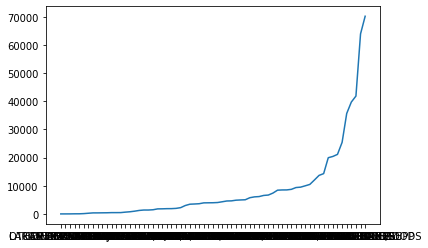

In [206]:
print(df_train_f1.drop('TripType', axis=1).sum(axis=0).sort_values())
plt.plot(df_train_f1.drop('TripType', axis=1).sum(axis=0).sort_values())

At this point, you could manually do some experiments to see if there are categories (like SEASONAL > 0) where all the TripTypes are the same. In this case, you could (and should) set a manual rule.

**Question**: For visits that involved buying seasonal items, what were the TripTypes?

In [207]:
df_train_f1[df_train_f1['SEASONAL']>0].shape

(21, 68)

In [208]:
df_train_f1['SEASONAL'].sum()

22.0

In [211]:
df_train_f1[df_train_f1['SEASONAL']>0]['TripType'].value_counts()

44    4
42    4
40    3
25    2
15    2
9     1
12    1
41    1
39    1
6     1
5     1
Name: TripType, dtype: int64

In [212]:
df_train_f1[df_train_f1['OTHER DEPARTMENTS']>0]['TripType'].value_counts()

999    19
38      3
6       1
15      1
9       1
Name: TripType, dtype: int64

In [213]:
df_train_f1[df_train_f1['CONCEPT STORES']>0]['TripType'].value_counts()

999    27
3       2
Name: TripType, dtype: int64

**Question**: Repeat this exercise for each department to see if there's any department which if it is present, results in > 95% of the trip types being of the same type

In [223]:
df_train_f1[df_train_f1['CONCEPT STORES']>0]['TripType'].value_counts().sum()

29

In [224]:
for col in df_train_f1.drop('TripType', axis=1).columns:
    counts = df_train_f1[df_train_f1[col]>0]['TripType'].value_counts()
    if counts.iloc[0] / counts.sum() > 0.95:
        print(col)

LARGE HOUSEHOLD GOODS
OPTICAL - LENSES


In [225]:
df_train_f1[df_train_f1['OPTICAL - LENSES']>0]['TripType'].value_counts()

5    44
Name: TripType, dtype: int64

In [226]:
df_train_f1[df_train_f1['LARGE HOUSEHOLD GOODS']>0]['TripType'].value_counts()

3      63
999     1
Name: TripType, dtype: int64

In this case, one could create a rule that predicts trip type 5 for any trip that had a visit to "OPTICAL - LENSES" or "LARGE HOUSEHOLD GOODS" except that combined they affect only ~100 visits.